In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from rich.progress import track
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, precision_score, recall_score, mean_squared_error
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import scipy.stats

## Multilayer Perceptron for classification

In [3]:
data2 = pd.read_csv('data/Part 2.tsv', sep='\t')
X = data2.loc[:, data2.columns != 'target'].values
y = data2['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [4]:
def sigmoid(Z):
    return 1.0 / (1.0 + np.exp(-Z))

def sigmoid_derivative(output):
    return output * (1.0 - output)

def cost_function(y, y_hat):
    return -np.sum(y*(np.log(y_hat)) + (1 - y)*np.log(1 - y_hat)) / y.shape[0]

def cost_gradient(y, y_hat):
    return -np.divide(y, y_hat) + np.divide(1.0 - y, 1.0 - y_hat)

In [5]:
class MultilayerPerceptron2Classification():
    """
    Implements a Multilayer Perceptron with n hidden layers
    for classification
    Each hidden layers must have a bias unit
    Use mini-batch gradient descent to update the weights
    Parameters:
    -----------
    learning_rate: A float number that determines the learning rate used for
updating the weights on the update step of the gradient descent.
    batch_size: An integer that determines the number of datapoints that
are included in each mini-batch
    epochs: An integer that determines the number of times the training
goes through all the datapoints
    hidden_layers: A list of integers that determines the number of nodes in
each hidden layer
    """
    def __init__(self, learning_rate=0.001, batch_size=10, epochs=1000, hidden_layers=[50, 50, 50, 50, 50]):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.hidden_layers_size = hidden_layers
        self.training_losses = np.zeros(self.epochs)
        self.layers_size = []
        self.weights = []
        self.As = []
        self.Zs = []
        self.Z = []
        self.D = []
    def initialize_weights(self, n_features):
        """
        Initialize the weights of the neural network
        Parameters:
        -----------
        n_features: An integer that determines the number of features in the
dataset
        """
        self.layers_size = [n_features] + self.hidden_layers_size + [self.output_layer_size]
        self.weights = [np.random.randn(x+1, y) for x, y in zip(self.layers_size, self.layers_size[1:])]

    def forward(self, X):
        """
        Calculate the forward propagation of the neural network
        Parameters:
        -----------
        X: A numpy array of shape (n_samples, n_features) that contains the
datapoints
        """
        self.As = []
        self.Zs = []
        Z = X 
        A = sigmoid(Z)
        n, _ = A.shape
        A = np.c_[np.ones((n, 1)), A]
        self.As.append(A)
        self.Zs.append(Z)

        Z = X @ self.weights[0]
        A = sigmoid(Z)
        n, _ = A.shape
        A = np.c_[np.ones((n, 1)), A]
        self.As.append(A)
        self.Zs.append(Z)
        
        for i in range(1, len(self.weights)-1):
            Z = A @ self.weights[i]
            A = sigmoid(Z)
            n, _ = A.shape
            A = np.c_[np.ones((n, 1)), A]
            self.As.append(A)
            self.Zs.append(Z)
        Z = A @ self.weights[-1]
        A = sigmoid(Z)
        self.As.append(A)
        self.Zs.append(Z)
        return A
    def backward(self, X, y):
        """
        Calculate the backward propagation of the neural network
        Parameters:
        -----------
        X: A numpy array of shape (n_samples, n_features) that contains the
datapoints
        y: A numpy array of shape (n_samples, 1) that contains the target
values
        """
        #check if adding a=input
        # last layer backprop (now with activation function)
        dWs = []
        dA = cost_gradient(y, self.As[-1])
        dZ = dA * sigmoid_derivative(sigmoid(self.Zs[-1]))
        dW = self.As[-2].T @ dZ
        dWs.append(dW)
        # hidden layers backprop
        for i in range(len(self.weights)-2, 0, -1):
            dA = dZ @ self.weights[i+1][1:, :].T
            dZ = dA * sigmoid_derivative(sigmoid(self.Zs[i+1]))
            dW = self.As[i].T @ dZ
            dWs.append(dW)
        # first layer backprop
        dA = dZ @ self.weights[1][1:, :].T
        dZ = dA * sigmoid_derivative(sigmoid(self.Zs[1]))
        dW = X.T @ dZ
        dWs.append(dW)
        dWs.reverse()
        return dWs

    def update_weights(self, dWs):
        """
        Update the weights of the neural network
        Parameters:
        -----------
        dWs: A list of numpy arrays that contains the derivatives of the
weights
        """
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * dWs[i]
    def fit(self, X, y):
        """
        Fit the neural network to the training data
        Parameters:
        -----------
        X: A numpy array of shape (n_samples, n_features) that contains the
datapoints
        y: A numpy array of shape (n_samples, 1) that contains the target
values
        """
        X, y = check_X_y(X, y)
        n, m = X.shape
        _X = np.c_[np.ones((n, 1)), X]
        _y = y[:, np.newaxis]
        try:
            self.output_layer_size = y.shape[1]
        except IndexError:
            self.output_layer_size = 1
    
        self.initialize_weights(m)

        n_batches = int(n + self.batch_size - 1) // self.batch_size

        for epoch in range(self.epochs):
            for b in range(n_batches):
                X_batch = _X[b*self.batch_size:(b+1)*self.batch_size]
                y_batch = _y[b*self.batch_size:(b+1)*self.batch_size]
                y_pred = self.forward(X_batch)
                dWs = self.backward(X_batch, y_batch)
                self.update_weights(dWs)
            y_pred = self.forward(_X)
            self.training_losses[epoch] = cost_function(_y, y_pred)
        self.fitted_ = True
    def predict(self, X):
        """
        Predict the target values of the datapoints
        Parameters:
        -----------
        X: A numpy array of shape (n_samples, n_features) that contains the
datapoints
        """
        return self.predict_proba(X).argmax(axis=1)
    
    def predict_proba(self, X):
        check_is_fitted(self)
        
        X = check_array(X)
        n, m = X.shape
        _X = np.c_[np.ones((n, 1)), X]
        
        pred_1 = self.forward(_X)
        pred_0 = 1 - pred_1
        return np.c_[pred_0, pred_1]

In [6]:
model2 = MultilayerPerceptron2Classification(learning_rate=0.0001, batch_size=32, epochs=100, hidden_layers=[4, 4, 4, 4])
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
auc_pr = average_precision_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("AUC-PR:", auc_pr)
print("AUC-ROC:", auc_roc)

Accuracy: 0.829
AUC-PR: 0.7675214069834307
AUC-ROC: 0.8289214501080897


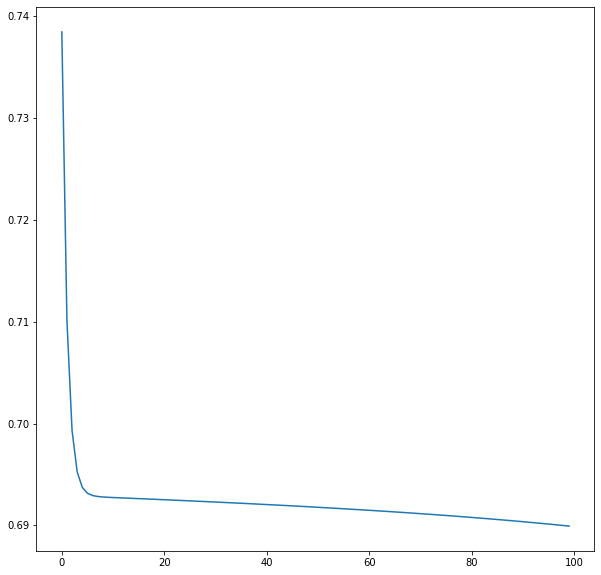

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(model2.training_losses)
plt.show()
plt.close("all")

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1196  300]
 [ 213 1291]]


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1196  300]
 [ 213 1291]]
